# Recipe: Time Series

## Overview

Time series analysis can provided additional insight into trends within your data.

## Recipe Goals

This recipe will demonstrate how to leverage Howso Engine's time series tools to make time series predictions.

In [1]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from howso import engine
from howso.engine import Trainee, Session
from howso.utilities import infer_feature_attributes

### Step 1. Load Data

The data we will be using is an example set of time series data for three stocks.

In [2]:
df = pd.read_csv('data/example_timeseries.csv')
df

,ID,f1,f2,f3,date
0,31855,245.470,262.970,244.950,2010-01-31
1,31855,253.030,254.790,238.610,2010-02-28
2,31855,268.290,271.060,253.030,2010-03-31
3,31855,273.260,281.210,268.290,2010-04-30
4,31855,251.150,277.590,239.430,2010-05-31
...,...,...,...,...,...
4751,164306,3318.488,3318.488,3227.954,2019-04-30
4752,164306,3103.766,3323.469,3103.766,2019-05-31
4753,164306,3321.692,3332.855,3096.812,2019-06-30
4754,164306,3371.001,3418.161,3345.877,2019-07-31


Plot data for visual understanding

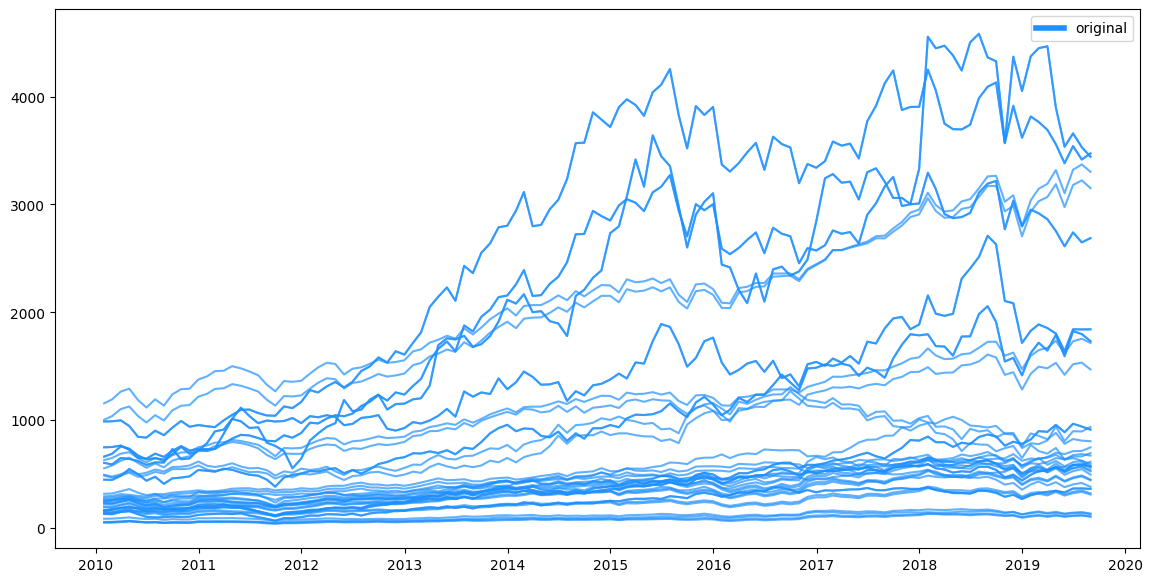

In [3]:
# Convert "date" column to `datetime` type.
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for series_id in df["ID"].unique():
    series_df = df.loc[df['ID'] == series_id].sort_values(by="date")
    ax.plot(series_df['date'], series_df['f1'], c="dodgerblue", alpha=0.7)

legend_elements = [
    Line2D([0], [0], color="dodgerblue", lw=4, label="original")
]

ax.legend(handles=legend_elements)

plt.show()

### Step 2. Set up Infer Feature Attributes with the correct date-time feature formats

In [4]:
# Identify id-feature and time-feature
id_feature_name = "ID"
time_feature_name = "date"
features = infer_feature_attributes(
    df,
    time_feature_name=time_feature_name,
    id_feature_name=id_feature_name
)

### Step 3: Build Trainee and make a time series prediction

The one change between regular analysis using non-time series data and time series data is that during the `train()` call, Engine calculates time information (deltas and rates) for each feature and adds this information in as additional features in your dataset. So, to utilize these new features which contain time information within the prediction, they have to be called as context features. The names of these features can be obtained after the `train()` call using the `get_cases()` call. Then, these can be passed in as context features to the `analyze()` and `react()` calls to make a time series prediction.

In [5]:
# Create the Trainee
t = Trainee(
    features=features,
    overwrite_existing=True
)

session1 = Session('train_session_1', metadata={'data': 'training data'})

# Train
t.train(df)

# Store actual record data which includes all of the ts information
cases_df = t.get_cases(
    session=session1
)

# Print out ts information
cases_df

The following parameters from configuration file will override the Amalgam parameters set in the code: {'trace'}


,ID,f1,f2,f3,date,.date_lag_1,.f2_lag_1,.series_progress_delta,.f1_rate_1,.f3_rate_1,.f1_lag_1,.f3_lag_1,.date_delta_1,.f2_rate_1,.series_progress
0,31855,245.470,262.970,244.950,2010-01-31,None,735.669362,0.008696,0.000002,0.000002,720.20159,693.845475,NaN,0.000002,0.000000
1,31855,253.030,254.790,238.610,2010-02-28,2010-01-31T00:00:00,262.970000,0.008002,0.000003,-0.000003,245.47000,244.950000,2419200.0,-0.000003,0.008002
2,31855,268.290,271.060,253.030,2010-03-31,2010-02-28T00:00:00,254.790000,0.008848,0.000006,0.000005,253.03000,238.610000,2674800.0,0.000006,0.016850
3,31855,273.260,281.210,268.290,2010-04-30,2010-03-31T00:00:00,271.060000,0.008574,0.000002,0.000006,268.29000,253.030000,2592000.0,0.000004,0.025424
4,31855,251.150,277.590,239.430,2010-05-31,2010-04-30T00:00:00,281.210000,0.008860,-0.000008,-0.000011,273.26000,268.290000,2678400.0,-0.000001,0.034284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751,164306,3318.488,3318.488,3227.954,2019-04-30,2019-03-31T00:00:00,3215.505000,0.008574,0.000049,0.000052,3191.16400,3092.292000,2592000.0,0.000040,0.964847
4752,164306,3103.766,3323.469,3103.766,2019-05-31,2019-04-30T00:00:00,3318.488000,0.008860,-0.000080,-0.000046,3318.48800,3227.954000,2678400.0,0.000002,0.973706
4753,164306,3321.692,3332.855,3096.812,2019-06-30,2019-05-31T00:00:00,3323.469000,0.008574,0.000084,-0.000003,3103.76600,3103.766000,2592000.0,0.000004,0.982280
4754,164306,3371.001,3418.161,3345.877,2019-07-31,2019-06-30T00:00:00,3332.855000,0.008860,0.000018,0.000093,3321.69200,3096.812000,2678400.0,0.000032,0.991140


Here, you can see the ts information that was added to the feature set when the data was trained into Engine. It is important that these time series features are added as context features for `analyze` and `react`.

In [6]:
# Specify Context and Action Features
action_features = ['f1']
context_features = cases_df.columns.drop(action_features).to_list()

# Targeted Analysis
t.analyze(context_features=context_features, action_features=action_features)

# Calculate overall error metrics
results = t.react_into_trainee(action_feature=action_features[0], residuals=True)
results = t.get_prediction_stats()
results['f1']

missing_value_accuracy          NaN
spearman_coeff             0.997591
mae                       25.739628
r2                         0.999266
rmse                      26.600206
recall                          NaN
accuracy                        NaN
precision                       NaN
Name: f1, dtype: float64

The prediction stats aboved were obtained using a discriminative `react()`. Now, we will use a generative `react()` to predict the f1 score at each point. For this, we will set the `desired_conviction` to be one, which indicates average surprisal for the generated cases.

In [7]:
initial_features = df.columns.tolist()
initial_values = []
context_values = cases_df[context_features]

for id in df.ID.unique():
    initial_values.append(df[df.ID == id].iloc[1].values.tolist())

In [8]:
# Here, we are making generative reacts for the entire dataset by providing the initial value
# which is the first actual case of each series and generating the rest. Time series may also
# be generated without providing the initial values.

action_features = df.columns.tolist()
initial_values = []
for id in df.ID.unique():
    initial_values.append(df[df.ID == id].iloc[1].values.tolist())

# Perform generative react
series_output =  t.react_series(
    action_features=action_features,
    initial_features=initial_features,
    initial_values=initial_values,
    final_time_steps= ['2019-07-31'],
    desired_conviction=1,
    generate_new_cases='always',
    num_series_to_generate=len(initial_values),
    series_id_tracking = 'fixed',
)
result_gen = series_output['action']


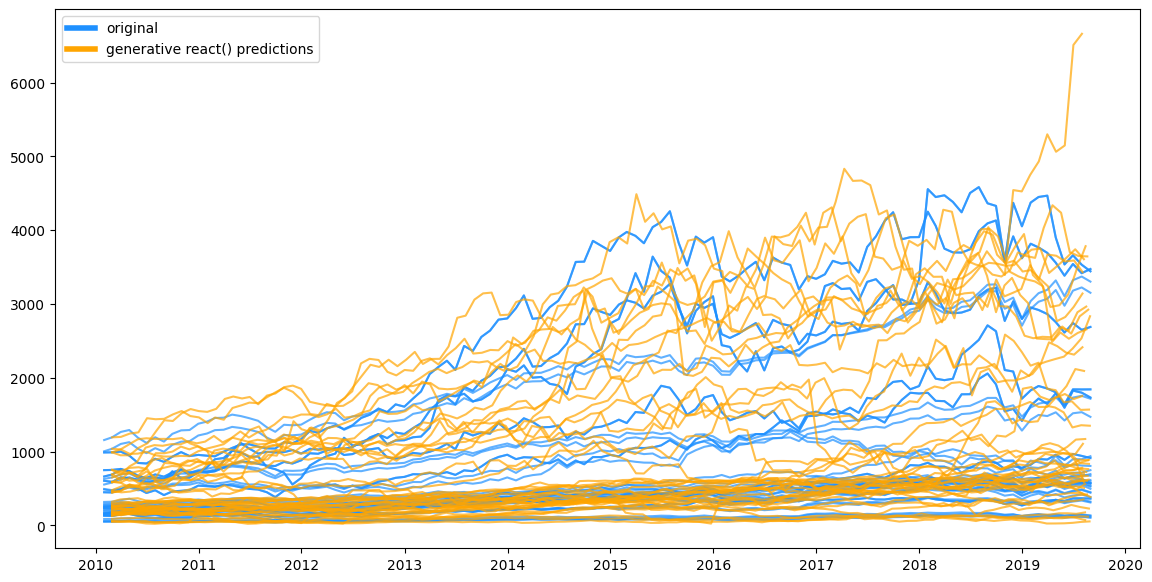

In [9]:
# Convert "date" column to `datetime` type.
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for series_id in df["ID"].unique():
    series_df = df.loc[df['ID'] == series_id].sort_values(by="date")
    ax.plot(series_df['date'], series_df['f1'], c="dodgerblue", alpha=0.7)

for series_id in result_gen["ID"].unique():
    result_df = result_gen.loc[result_gen['ID'] == series_id].sort_values(by="date")
    ax.plot(result_df['date'], result_df['f1'], c="orange", alpha=0.7)


legend_elements = [
    Line2D([0], [0], color="dodgerblue", lw=4, label="original"),
    Line2D([0], [0], color="orange", lw=4, label="generative react() predictions"),
]

ax.legend(handles=legend_elements)

plt.show()

# Note: The first case in each time series is not graphed as it is provided and thus not generated